In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d gowrishankarp/newspaper-text-summarization-cnn-dailymail -p /content

Dataset URL: https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail
License(s): CC0-1.0


In [4]:
!unzip /content/newspaper-text-summarization-cnn-dailymail.zip -d /content/newspaper-text-summarization-cnn-dailymail

Archive:  /content/newspaper-text-summarization-cnn-dailymail.zip
  inflating: /content/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv  
  inflating: /content/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv  
  inflating: /content/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv  


In [10]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers as L
from tensorflow.keras import models as M
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
TEXT_LIMIT = 1600
SUMMARY_LIMIT = 500

In [7]:
train_df = pd.read_csv("/content/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv")
train_df = train_df[train_df['article'].apply(lambda x: len(x) < TEXT_LIMIT)]
train_df = train_df[train_df['highlights'].apply(lambda x: len(x) < SUMMARY_LIMIT)]
train_df = train_df.reset_index().drop(['index', 'id'], axis=1)


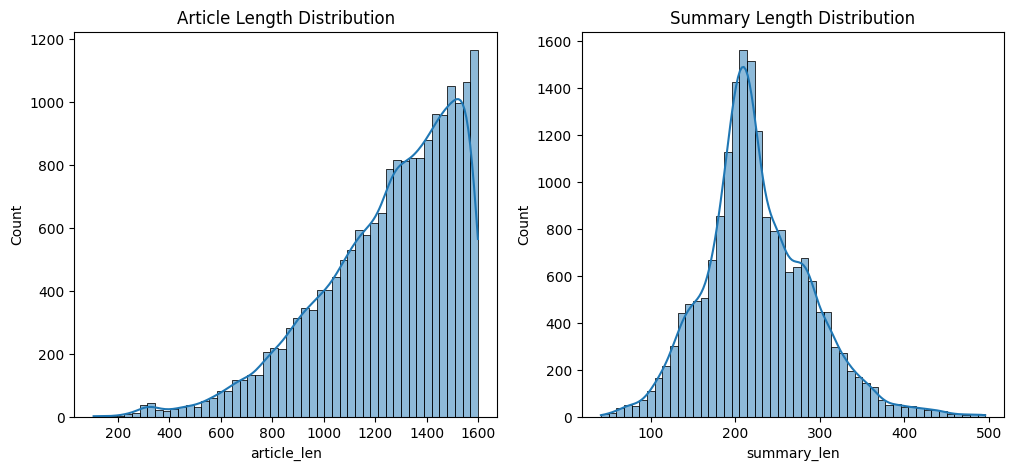

In [11]:
train_df['article_len'] = train_df['article'].apply(len)
train_df['summary_len'] = train_df['highlights'].apply(len)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['article_len'], bins=50, kde=True)
plt.title("Article Length Distribution")

plt.subplot(1, 2, 2)
sns.histplot(train_df['summary_len'], bins=50, kde=True)
plt.title("Summary Length Distribution")
plt.show()

In [ ]:
input_texts, target_summaries = np.array(train_df.iloc[:, 0:1]), np.array(train_df.iloc[:, 1:2])
input_texts = input_texts.reshape(input_texts.shape[0])
target_summaries = target_summaries.reshape(target_summaries.shape[0])

In [ ]:
START_TOKEN = '<start>'
END_TOKEN = '<end>'
PAD_TOKEN = '<PAD>'

In [ ]:
target_summaries = [f"{START_TOKEN} {text} {END_TOKEN}" for text in target_summaries]

In [ ]:
test_split_size = -10
input_test, summary_test = input_texts[test_split_size:], target_summaries[test_split_size:]
input_texts, target_summaries = input_texts[:test_split_size], target_summaries[:test_split_size]

encoder_tokenizer = Tokenizer()

In [ ]:
encoder_tokenizer = Tokenizer()
decoder_tokenizer = Tokenizer()
encoder_tokenizer.fit_on_texts(input_texts)
decoder_tokenizer.fit_on_texts(target_summaries)

In [ ]:
start_token_id = decoder_tokenizer.word_index.get(START_TOKEN.strip('<>'))
end_token_id = decoder_tokenizer.word_index.get(END_TOKEN.strip('<>'))
pad_token_id = 0

In [ ]:
input_vocab_size = len(encoder_tokenizer.word_index) + 1
output_vocab_size = len(decoder_tokenizer.word_index) + 1

In [ ]:
encoder_input_sequences = encoder_tokenizer.texts_to_sequences(input_texts)
decoder_target_sequences = decoder_tokenizer.texts_to_sequences(target_summaries)

In [ ]:
sequence_max_length = lambda seqs: max([len(s) for s in seqs]) + 1
max_input_seq_length = sequence_max_length(encoder_input_sequences)
max_output_seq_length = sequence_max_length(decoder_target_sequences)

In [ ]:
encoder_input_sequences = np.array(pad_sequences(encoder_input_sequences, padding='post', truncating='post', maxlen=max_input_seq_length))
decoder_target_sequences = pad_sequences(decoder_target_sequences, padding='post', truncating='post', maxlen=max_output_seq_length)

In [ ]:
decoder_input_sequences = np.array(decoder_target_sequences[:, :-1])
decoder_targets = np.array(decoder_target_sequences[:, 1:])

In [ ]:
class BahdanauAttention(L.Layer):
    def __init__(self, attention_units):
        super(BahdanauAttention, self).__init__()
        self.W1 = L.Dense(attention_units)
        self.W2 = L.Dense(attention_units)
        self.V = L.Dense(1)

    def call(self, decoder_query, encoder_outputs):
        query_with_time_axis = tf.expand_dims(decoder_query, axis=1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(encoder_outputs)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_outputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
class TextEncoder(L.Layer):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(TextEncoder, self).__init__()
        self.embedding = L.Embedding(vocab_size, embedding_dim)
        self.lstm = L.LSTM(lstm_units, return_state=True)

    def call(self, inputs):
        embedded = self.embedding(inputs)
        output, hidden_state, cell_state = self.lstm(embedded)
        return output, hidden_state, cell_state

In [ ]:
class TextDecoder(L.Layer):
    def __init__(self, vocab_size, embedding_dim, lstm_units):
        super(TextDecoder, self).__init__()
        self.embedding = L.Embedding(vocab_size, embedding_dim)
        self.lstm = L.LSTM(lstm_units, return_sequences=True, return_state=True)
        self.output_layer = L.Dense(vocab_size, activation='softmax')

    def call(self, inputs, states):
        embedded = self.embedding(inputs)
        lstm_output, hidden, cell = self.lstm(embedded, initial_state=states)
        logits = self.output_layer(lstm_output)
        return logits, hidden, cell

In [ ]:
@keras.saving.register_keras_serializable(package="Custom", name="TextSummarizationModel")
class TextSummarizationModel(M.Model):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, lstm_units):
        super(TextSummarizationModel, self).__init__()
        self.encoder = TextEncoder(input_vocab_size, embedding_dim, lstm_units)
        self.decoder = TextDecoder(output_vocab_size, embedding_dim, lstm_units)
        self.input_vocab_size = input_vocab_size
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units

In [ ]:
@keras.saving.register_keras_serializable(package="Custom", name="TextSummarizationModel")
class TextSummarizationModel(M.Model):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, lstm_units):
        super(TextSummarizationModel, self).__init__()
        self.encoder = TextEncoder(input_vocab_size, embedding_dim, lstm_units)
        self.decoder = TextDecoder(output_vocab_size, embedding_dim, lstm_units)
        self.input_vocab_size = input_vocab_size
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units

    def train_step(self, data):
        (encoder_inputs, decoder_inputs), targets = data
        with tf.GradientTape() as tape:
            _, enc_hidden, enc_cell = self.encoder(encoder_inputs)
            decoder_output, _, _ = self.decoder(decoder_inputs, [enc_hidden, enc_cell])
            loss = self.compiled_loss(targets, decoder_output)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(targets, decoder_output)
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False):
        encoder_inputs, decoder_inputs = inputs
        _, enc_hidden, enc_cell = self.encoder(encoder_inputs)
        decoder_output, _, _ = self.decoder(decoder_inputs, [enc_hidden, enc_cell])
        return decoder_output

    def generate_summary(self, encoder_input, max_len=max_output_seq_length, start_id=start_token_id, end_id=end_token_id):
        encoder_output, enc_hidden, enc_cell = self.encoder(encoder_input)
        decoder_state = [enc_hidden, enc_cell]
        decoder_input = tf.expand_dims([start_id], 0)
        generated_ids = []
        for _ in range(max_len):
            predictions, hidden, cell = self.decoder(decoder_input, states=decoder_state)
            predicted_id = tf.argmax(predictions[0, -1, :])
            if predicted_id == end_id:
                break
            generated_ids.append(predicted_id.numpy())
            decoder_input = tf.expand_dims([predicted_id.numpy()], 0)
            decoder_state = [hidden, cell]
        return generated_ids

    def get_config(self):
        config = super().get_config()
        config.update({
            'input_vocab_size': self.input_vocab_size,
            'output_vocab_size': self.output_vocab_size,
            'embedding_dim': self.embedding_dim,
            'lstm_units': self.lstm_units
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
summary_model = TextSummarizationModel(
    input_vocab_size=input_vocab_size,
    output_vocab_size=output_vocab_size,
    embedding_dim=512,
    lstm_units=512
)

In [ ]:
summary_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
for _ in range(5):
    summary_model.fit((encoder_input_sequences, decoder_input_sequences), decoder_targets, batch_size=32, epochs=5, validation_split=0.2)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


470/470 ━━━━━━━━━━━━━━━━━━━━ 202s 413ms/step - accuracy: 0.5917 - loss: 2.3843e-05 - val_accuracy: 0.6254 - val_loss: 2.9869
Epoch 2/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 210s 436ms/step - accuracy: 0.6258 - loss: 2.3844e-05 - val_accuracy: 0.6432 - val_loss: 2.7872
Epoch 3/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 258s 428ms/step - accuracy: 0.6450 - loss: 2.3844e-05 - val_accuracy: 0.6524 - val_loss: 2.6481
Epoch 4/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 209s 445ms/step - accuracy: 0.6564 - loss: 2.3844e-05 - val_accuracy: 0.6566 - val_loss: 2.5762
Epoch 5/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 257s 435ms/step - accuracy: 0.6645 - loss: 2.3844e-05 - val_accuracy: 0.6605 - val_loss: 2.5351
Epoch 1/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 209s 445ms/step - accuracy: 0.6733 - loss: 2.3844e-05 - val_accuracy: 0.6634 - val_loss: 2.5228
Epoch 2/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 257s 435ms/step - accuracy: 0.6819 - loss: 2.3844e-05 - val_accuracy: 0.6645 - val_loss: 2.5247
Epoch 3/5
470/470 ━━━━━━━━━━━━━━━━━━━━ 259s 430ms/step - accuracy

In [ ]:
summary_model.save('Teacher_Model.keras')


In [ ]:
index_to_word = {v: k for k, v in decoder_tokenizer.word_index.items()}


In [ ]:
def predict_summary_output(index, model=summary_model, source_tokenizer=encoder_tokenizer, target_tokenizer=decoder_tokenizer, source_len=max_input_seq_length, target_len=max_output_seq_length):
    input_seq = source_tokenizer.texts_to_sequences([input_texts[index]])
    input_seq = pad_sequences(input_seq, maxlen=source_len, padding='post')
    generated_ids = model.generate_summary(input_seq, target_len, start_token_id, end_token_id)

    generated_summary = []
    for token_id in generated_ids:
        word = index_to_word.get(token_id, '')
        if word:
            generated_summary.append(word)

    print("INPUT TEXT")
    print(input_texts[index])
    print("\nGENERATED SUMMARY")
    print(' '.join(generated_summary))
    print("\nREFERENCE SUMMARY")
    print(target_summaries[index][7:-5])

In [ ]:
predict_summary_output(1116)


INPUT TEXT
(CNN) -- Rescue workers have pulled a body from underneath the rubble of a collapsed apartment building in Cologne, Germany, police spokeswoman Astrid Gelss told CNN. The remains of Cologne's archive building following the collapse on Tuesday afternoon. The apartment building collapsed together with two other buildings on March 3. Initially as many as nine people were reported missing, but after seven of them reported to the authorities that they were safe, search and rescue efforts focused on finding the two remaining missing men. Rescue workers found the body at about 2 a.m. Sunday morning (8 p.m. ET Saturday). It has not been identified. The search for the second missing person is still ongoing, Gelss said. It is still not clear what caused the collapse of the building which contained the city's historical archives, bringing down parts of the two nearby structures. CNN's Per Nyberg contributed to this report.

GENERATED SUMMARY
new the death toll rises to 931 according to

In [ ]:
predict_summary_output(100)


INPUT TEXT
Los Angeles (CNN) -- Michael Jackson's brothers are working on a reunion tour to perform their old Jackson 5 songs, Jermaine Jackson said Monday. "Michael would want us to continue on," Jackson said, after he unveiled an exhibit of his brother's wax statues at Madame Tussauds in Hollywood. Saturday marks the second anniversary of the pop icon's sudden death, which the coroner ruled was from an overdose of a surgical anesthetic. "The brothers now are ready just to keep the legacy going and the music," Jackson said. "We're meeting today about putting a tour together just to play the music because it's such wonderful music. We need to continue to play this music because it's healing for us." Jackson did not say which of his brothers were involved in the talks. Recent attempts to reunite the brothers on stage were met with frustration and division, including the effort documented by an A&E Network reality show in 2009. Monday's unveiling was a reunion of sorts for Michael Jackso

NameError: name 'predict_summary_output' is not defined